In [2]:
# Only when is Local
import findspark

findspark.init()
findspark.find()

'E:\\LibreriasPython\\spark-3.1.2-bin-hadoop2.7\\python\\pyspark'

In [6]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

# **03 Testeo Pipeline Spark**
--------------------------------

**Agenda**

- Importancia de Testeo de Software
- Testeo Pipeline
-FrameWork para los test: PyDque


In [ ]:
# Instalamos Spark  
!pip install pyspark py4j
!pip install pydeequ

     |████████████████████████████████| 281.4 MB 31 kB/s 
     |████████████████████████████████| 198 kB 52.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=5645da0114605d7ac70c04ab690f6f571af8fff10b535b75e20a999810555756
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


## **1.Importancia del Testeo de Software**






La importancia del testing de software y de la automatización de pruebas. El testing de software es una de las actividades más importantes y fundamentales en el desarrollo de un proyecto, ya que posibilita los procesos, métodos de trabajo y herramientas necesarias para garantizar la calidad de cualquier desarrollo.


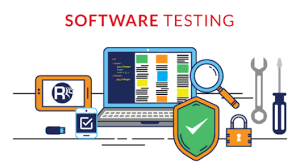


## **2.Prueba Unitaria**


Las pruebas unitarias consisten en verificar el comportamiento de las unidades más pequeñas de su aplicación. Técnicamente, eso sería una clase o incluso un método de clase en los lenguajes orientados a objetos, y un procedimiento o función en los lenguajes procedimentales y funcionales.

### Pruebas Unitarias PySpark

In [ ]:
# Supongamos que tenemos un archivo que queremos probar

def link_with_exchange_rates(prices, rates):
  return prices.join(rates, ["currency","date"])

def calculate_unit_price_in_euro(df):
  return df.withColumn("unit_price_in_euro",
                       col("price") / col("quantity") * col("exchange_rate_to_euro")
                       )
  

# Programa Principal
unit_prices_with_ratings = (calculate_unit_price_in_euro(
                                  link_with_exchange_rates(prices, exchange_rates)
                                  )
                            )

In [ ]:
# Prueba Unitaria 
import unittest



def are_dfs_equal(df1, df2):
    if df1.schema != df2.schema:
        return False
    if df1.collect() != df2.collect():
        return False
    return True

def test_calculate_unit_price_in_euro():
  
  # Generando registro prueba
  record = dict(price=10,
                quantity=5,
                exchange_rate_to_euro=2.)
  
  # Aplicando funcion
  df = spark.createDataFrame([Row(**record)])
  result = calculate_unit_price_in_euro(df)
  
  # resultado Esperado
  expected_record = Row(**record, unit_price_in_euro=4.)
  expected = spark.createDataFrame([expected_record])
  
  assert are_dfs_equal(result, expected)



# aplicando prueba unitaria
test_calculate_unit_price_in_euro()




## **3.Pruebas de Calidad**

## **4. FrameWork para los test: PyDque**


PyDeequ es una API de Python para Deequ, una biblioteca construida sobre Apache Spark para definir "pruebas unitarias para datos", que miden la calidad de los datos en grandes conjuntos de datos. PyDeequ está escrito para admitir el uso de Deequ en Python.


<img src="https://github.com/awslabs/python-deequ/raw/master/imgs/pydeequ_architecture.jpg">


In [3]:
from pyspark.sql import SparkSession, Row
import pydeequ

# Generamos Spark
spark = (SparkSession
    .builder
    .config("spark.jars.packages", pydeequ.deequ_maven_coord)
    .config("spark.jars.excludes", pydeequ.f2j_maven_coord)
    .getOrCreate())

# Lectura Df Test
df = spark.sparkContext.parallelize([
            Row(a="foo", b=1, c=5),
            Row(a="bar", b=2, c=6),
            Row(a="baz", b=3, c=None)]).toDF()

Please set env variable SPARK_VERSION


In [4]:
df.show()

+---+---+----+
|  a|  b|   c|
+---+---+----+
|foo|  1|   5|
|bar|  2|   6|
|baz|  3|null|
+---+---+----+



In [ ]:
from pydeequ.analyzers import *

# Estableciendo análisis 
analysisResult = (AnalysisRunner(spark)
                    # Df analizar
                    .onData(df)
                    # Cantidad Registros
                    .addAnalyzer(Size())
                    # Prueba completitud sobre columna 'b'
                    .addAnalyzer(Completeness("b"))
                    .run()
)

# Mostrando resultados
analysisResult_df = AnalyzerContext.successMetricsAsDataFrame(spark, analysisResult)
analysisResult_df.show()

+-------+--------+------------+-----+
| entity|instance|        name|value|
+-------+--------+------------+-----+
|Dataset|       *|        Size|  3.0|
| Column|       b|Completeness|  1.0|
+-------+--------+------------+-----+



- **Verificación de restricciones**

Colocando resultados


In [ ]:
from pydeequ.checks import *
from pydeequ.verification import *

check = Check(spark, CheckLevel.Warning, "Review Check")

checkResult = (VerificationSuite(spark)
    .onData(df)
    .addCheck(
        # listado pruebas
        check.hasSize(lambda x: x >= 3) #cantidad de registros
        .hasMin("b", lambda x: x == 0) #en la column "b" el valor minimo sea 0
        .isComplete("c")
        .isUnique("a") #test de llaves unicas  
        .isContainedIn("a", ["foo", "bar", "baz"])
        .isNonNegative("b")) #test de valores no negativos
    .run()
)

checkResult_df = VerificationResult.checkResultsAsDataFrame(spark, checkResult)
checkResult_df.show(truncate=False)

In [7]:
# Finalizando spark context
spark.sparkContext._gateway.shutdown_callback_server()
spark.stop()

# Referencias



- [Pydeequ](https://github.com/awslabs/python-deequ)

- [Guia Pydeequ AWS](https://aws.amazon.com/es/blogs/big-data/testing-data-quality-at-scale-with-pydeequ/)

- [Pydeequ Documentation](https://pydeequ.readthedocs.io/en/latest/)

- [Unit Test Spark](https://towardsdatascience.com/testing-pyspark-dataframe-transformations-d3d16c798a84)